With the cryptocurrency tumble that happened recently, the finance knowledge in me was screaming to pick a dataset and show the importance of diversification, especially after reading some articles that discussed how people went "all-in" on crypto...

This notebook walks through the importance of diversification by first looking at realized returns from NSE data when just investing in a single stock and when investing in two stocks within a portfolio. Then, it leads to generalizing the concept of portfolio optimization by walking through an example with the PyPortfolioOpt package.

In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load in NYSE data
data = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv', parse_dates = True)
data.tail()

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


For the first part of this analysis, we will pick two stocks and assume we invest a hundred dollars in them at the start of 2016 and hold until the end of 2016. How will they do?

In [3]:
#Pick two stocks for 2016: ZBH (Zimmer Biomet) & WLTW (Willis Towers Watson)
WLTW = data.loc[(data.symbol == 'WLTW') & (data.date >= '2016-01-05') & (data.date <= '2016-12-31')]
ZBH = data.loc[(data.symbol == 'ZBH') & (data.date >= '2016-01-05') & (data.date <= '2016-12-31')]

WLTW.reset_index(inplace = True)
ZBH.reset_index(inplace = True)

WLTW = WLTW.drop('index', axis = 1)
ZBH = ZBH.drop('index', axis = 1)

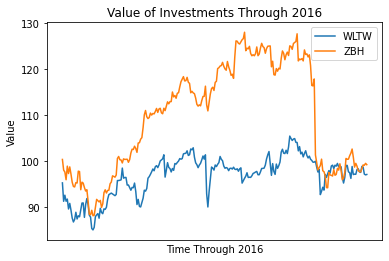

In [4]:
#Invest $100 in each stock on Jan 5th and hold until Dec 30th - how do they move (close price)?
WLTW['daily_close_return'] = WLTW.close.pct_change()
ZBH['daily_close_return'] = ZBH.close.pct_change()

WLTW.dropna(inplace = True)
ZBH.dropna(inplace = True)

WLTW['returns_100'] = 100 * np.cumprod(WLTW.daily_close_return + 1)
ZBH['returns_100'] = 100 * np.cumprod(ZBH.daily_close_return + 1)

plt.plot(WLTW.date, WLTW.returns_100)
plt.plot(ZBH.date, ZBH.returns_100)
plt.legend(['WLTW', 'ZBH'])
plt.xticks([])
plt.title('Value of Investments Through 2016')
plt.xlabel('Time Through 2016')
plt.ylabel('Value')
plt.show()

From the above plot, we can see they ended up in about the same spot. ZBH was doing fantastic until a huge drop hit later in the year to put them both in line.

What are the returns and standard deviations (risk)? These can be seen below.

In [5]:
#Mean and standard deviation of both
print(('Mean of WLTW: ' + str(round((WLTW.returns_100.values[-1] - 100) / 100, 2))))
print('Standard Deviation of WLTW: ' + str(round(np.std(WLTW.daily_close_return) * np.sqrt(len(WLTW.daily_close_return)), 2)))

print(('Mean of ZBH: ' + str(round((ZBH.returns_100.values[-1] - 100) / 100, 2))))
print('Standard Deviation of ZBH: ' + str(round(np.std(ZBH.daily_close_return) * np.sqrt(len(ZBH.daily_close_return)), 2)))

Mean of WLTW: -0.03
Standard Deviation of WLTW: 0.23
Mean of ZBH: -0.01
Standard Deviation of ZBH: 0.24


Both had negative returns and fairly high standard deviations (which is to be expected when investing in single stocks). What would happen if we invested fifty dollars in each stock within a hundred dollar portfolio?

We will plot this portfolio in addition to the ones above.

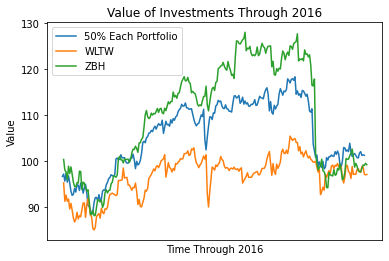

In [6]:
#50% weighting to each stock
df_WLTW_ZBH = pd.concat([WLTW[['date', 'close']], ZBH.close], axis = 1)
df_WLTW_ZBH.columns = ['date', 'WLTW', 'ZBH']
df_WLTW_ZBH.WLTW = df_WLTW_ZBH.WLTW.pct_change()
df_WLTW_ZBH.ZBH = df_WLTW_ZBH.ZBH.pct_change()
df_WLTW_ZBH = df_WLTW_ZBH.dropna()
df_WLTW_ZBH['port_return'] = 0.5 * df_WLTW_ZBH.WLTW + 0.5 * df_WLTW_ZBH.ZBH
df_WLTW_ZBH['port_return_100'] = 100 * np.cumprod(df_WLTW_ZBH.port_return + 1)
plt.plot(df_WLTW_ZBH.date, df_WLTW_ZBH.port_return_100)
plt.plot(WLTW.returns_100)
plt.plot(ZBH.returns_100)
plt.legend(['50% Each Portfolio', 'WLTW', 'ZBH'])
plt.xticks([])
plt.title('Value of Investments Through 2016')
plt.xlabel('Time Through 2016')
plt.ylabel('Value')
plt.show()

For the most part, we see returns that are in between the returns generated from the two assets separately. However, this changes near the end when ZBH has a massive drop. Essentially, by diversifying our portfolio, we are being less risky since these two assets are not perfectly correlated (they do not move in the same direction every day). As a result, we end up better off at the end of 2016 than if we invested in just one of the stocks. More specifically, we can see the realized return and standard deviation below.

In [7]:
#By diversifying, not only did we have a positive return, but we also had lower risk than both stocks
print(('Mean of Portfolio: ' + str(round((df_WLTW_ZBH.port_return_100.values[-1] - 100) / 100, 2))))
print('Standard Deviation of Portfolio: ' + str(round(np.std(df_WLTW_ZBH.port_return) * np.sqrt(len(df_WLTW_ZBH.port_return)), 2)))

Mean of Portfolio: 0.01
Standard Deviation of Portfolio: 0.19


While we calculated *realized* return and standard deviation, we can generalize more with *expected* return and standard deviation to show how diversification can imply similar returns with less risk. Formulas are below. I will not go into great detail, but if you are curious I encourage you to explore further. There are some excellent videos and readings that go into more depth.

While a portfolio's expected return is pretty intuitive, the standard deviation is not since you need to take into account the correlation between the two stocks.

w = weight

r = expected return

σ = standard deviation

ρ = correlation coefficient

Expected Return: uP = wA * rA + wB * rB

Standard Deviation: σP = √(wA^2 * σA^2 + wB^2 * σB^2 + 2 * wA * wB * σA * σB * ρAB)

So what if we assume in the next year that the expected returns of the two stocks we looked at are going to be the realized return we calculated? How should we weight each stock in order to get the most "bang for our buck" (best risk to reward ratio) in our portfolio besides just doing a 50/50 split? 

This is where we can use the pyportfolioopt package to generate something called the efficient frontier, which is weighting assets within a portfolio in a way to give us the greatest return for a certain level of risk (standard deviation).

In [8]:
#Install PyPortfolioOpt
! pip install PyPortfolioOpt

     |████████████████████████████████| 56 kB 1.5 MB/s 
     |████████████████████████████████| 1.3 MB 3.8 MB/s 
  Installing build dependencies ... - \ | / - \ | / - \ | done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... - \ done
  Created wheel for cvxpy: filename=cvxpy-1.1.12-cp37-cp37m-linux_x86_64.whl size=2733118 sha256=80094fd16717ba717c6683cd75237a33d464b659d144b9ae2cfd1381eb736ff2
  Stored in directory: /root/.cache/pip/wheels/0c/c5/a5/bd7a06743cd4504096d9690d8c3e1ac21dfaec5b222aa6cb39
Successfully built cvxpy
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.1.7
    Uninstalling cvxpy-1.1.7:
      Successfully uninstalled cvxpy-1.1.7


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

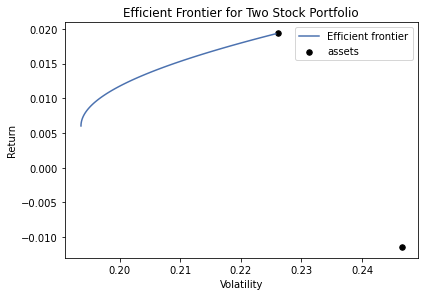

In [9]:
#Generate efficient frontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting

df_WLTW_ZBH = pd.concat([WLTW[['close']], ZBH.close], axis = 1)
df_WLTW_ZBH.columns = ['WLTW', 'ZBH']
mu = mean_historical_return(df_WLTW_ZBH)
S = sample_cov(df_WLTW_ZBH)

ef = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef)
plt.title('Efficient Frontier for Two Stock Portfolio')
plt.show()

Since we only have two assets, it is a bit difficult to interpret, but essentially what this is saying is that we can weight these two assets in ways that put us along the blue line. So if we would like to generate the least amount of risk (volatility), our expected return would be around 0.005. If we would like to generate the highest return and still be most efficient, we would invest in WLTW 100%.

Another interesting thing to note is that just investing in ZBH is inefficient. If we wanted to be less risky and still generate more returns, we would just invest in WLTW (assuming our expected return and standard deviation hold true into the future).

So how can we make this a more interesting and challenging problem? Let's test out this same approach but with many different assets besides just two and see the results, still assuming our expected returns are the realized returns over 2016.

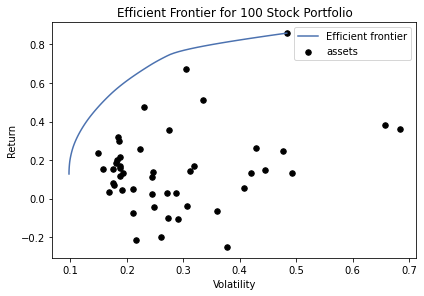

In [10]:
#Pick 50 different stocks
np.random.seed(777)

stocks_random = np.random.choice(data.loc[(data.date >= '2016-01-05') & (data.date <= '2016-12-31')].symbol.unique(), 50)

stocks_50 = data.loc[data.symbol.isin(stocks_random)]

stocks_50_wide = stocks_50[['date', 'symbol', 'close']].pivot_table(index = 'date',
                                           columns = 'symbol',
                                           values = 'close')

stocks_50_wide = stocks_50_wide.loc[(stocks_50_wide.index >= '2016-01-05') & (stocks_50_wide.index <= '2016-12-31')]

mu = mean_historical_return(stocks_50_wide)
S = sample_cov(stocks_50_wide)

ef = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef)
plt.title('Efficient Frontier for 100 Stock Portfolio')
plt.show()

Comparing this plot to our two stock plot, one can notice that we can achieve better returns for less risk, a very important point about diversification (you might recall the phrase "Don't put all of your eggs in one basket" which is very relevant here). As we continue adding stocks that are not perfectly correlated with our portfolio, we can reduce risk and maintain a desired return level. However, it is worth it to point out that it is nearly impossible to get positive returns with zero risk. If this opportunity is present, there are (most likely) people that will find it immediately and exploit it, taking profits until the opportunity is no longer there.

Let's look at one last plot that mirrors an excellent example from the PyPortfolioOpt documentation. It has a couple additional items to better illustrate certain points. First, it has many different portfolios below the efficient frontier. In essence, these are all inefficient since they do not fall on the efficient frontier. However, as the points get more blue (closer to the efficient frontier), it shows that they are more efficient. Also, the plot below has a star on it to indicate the optimal portfolio indicated by the maximum sharpe ratio. While I will not go into depth on this, one can think of it as the most "bang for your buck" that we originally set out to answer.

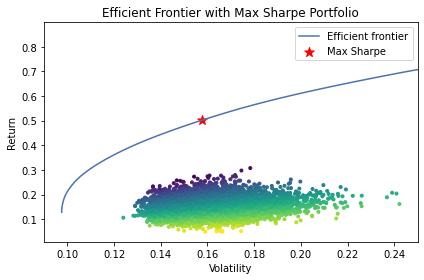

In [11]:
#Pretty it up for full clarification from pyportfolioopt package documentation
mu = mean_historical_return(stocks_50_wide)
S = sample_cov(stocks_50_wide)

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets = False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with Max Sharpe Portfolio")
plt.xlim([0.09, 0.25])
ax.legend()
plt.tight_layout()
plt.show()

I hope this notebook gave you some important insight into the power of diversification and portfolio optimization that can be demonstrated through Python. While there are many headlines that mention how someone got rich off of investing in bitcoin or Tesla, it is important to point out that this does not usually happen, and it is not a time tested strategy for successful investing. Plus, it is not highlighting the people that tried this on another stock (like a penny stock) and lost a lot of money, just like what might have happened to some with the large bitcoin plunge. 

So the next time there is a "hot" or "trendy" stock that everyone is investing in, make sure to take a step back, remember your overall investing goals and risk appetite, and come to a fair assessment of how you would like to proceed.